In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68616192/68606236 [==============================] - 69s 1us/step


In [3]:
base_dir = Path(zip_dir).parent/"cats_and_dogs_filtered"
train_dir = base_dir/'train'
validation_dir = base_dir/'validation'

train_cats_dir = train_dir/'cats'
train_dogs_dir = train_dir/'dogs'
validation_cats_dir = validation_dir/'cats'
validation_dogs_dir = validation_dir/'dogs'

In [4]:
# .glob("") создает итератор по всем файлам в директории
num_cats_tr = len(list(train_cats_dir.glob("*")))
num_dogs_tr = len(list(train_dogs_dir.glob("*")))

num_cats_val = len(list(validation_cats_dir.glob("*")))
num_dogs_val = len(list(validation_dogs_dir.glob("*")))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [5]:
print('Cats train: ', num_cats_tr)
print('Dogs train: ', num_dogs_tr)

print('Cats test: ', num_cats_val)
print('Dogs test: ', num_dogs_val)

Cats train:  1000
Dogs train:  1000
Cats test:  500
Dogs test:  500


(499, 459, 3)
(474, 500, 3)


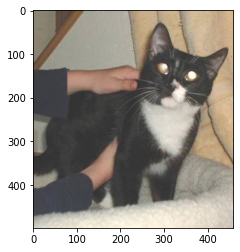

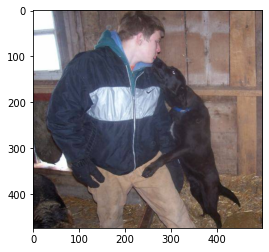

In [6]:
image_path = str(list(validation_cats_dir.glob("*"))[0])
image = plt.imread(image_path)
plt.figure()
plt.imshow(image)
print(image.shape)

image_path = str(list(validation_dogs_dir.glob("*"))[3])
image = plt.imread(image_path)
plt.figure()
plt.imshow(image)
print(image.shape)

In [7]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator  = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255) 

In [9]:
train_data_gen = train_image_generator.flow_from_directory(
                                        batch_size=BATCH_SIZE,
                                        directory=train_dir, 
                                        shuffle=True,
                                        target_size=(IMG_SHAPE,IMG_SHAPE), 
                                        class_mode='binary') 

val_data_gen = validation_image_generator.flow_from_directory(
                                        batch_size=BATCH_SIZE,
                                        directory=validation_dir,
                                        shuffle=False,
                                        target_size=(IMG_SHAPE,IMG_SHAPE), 
                                        class_mode='binary')

train_data_gen.class_indices

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


{'cats': 0, 'dogs': 1}

In [10]:
sample_training_images, sample_labels = next(train_data_gen)
sample_training_images.shape, sample_labels.shape 

((100, 150, 150, 3), (100,))

In [11]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

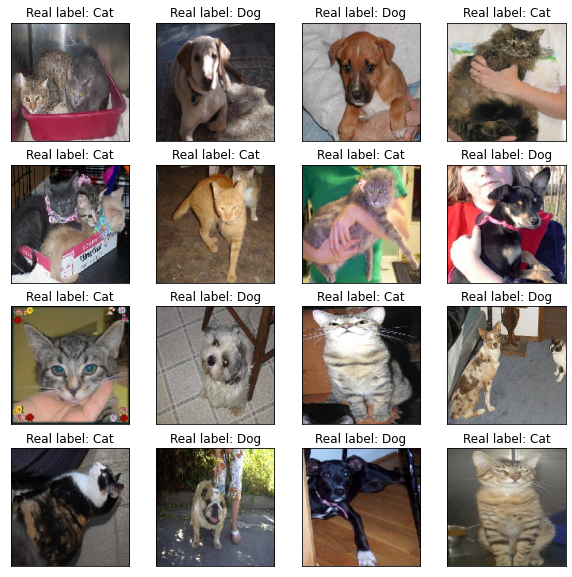

In [12]:
show_catsdogs(sample_training_images, sample_labels)
sample_training_images, sample_labels = next(train_data_gen)

In [14]:
# Real-time data visualization
from livelossplot.tf_keras import PlotLossesCallback

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), 
                                 activation='relu', input_shape=(150, 150, 3))) 
model.add( tf.keras.layers.MaxPooling2D(2, 2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                 activation='relu')) 
model.add( tf.keras.layers.MaxPooling2D(2, 2))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), 
                                 activation='relu')) 
model.add( tf.keras.layers.MaxPooling2D(2, 2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu')) 
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

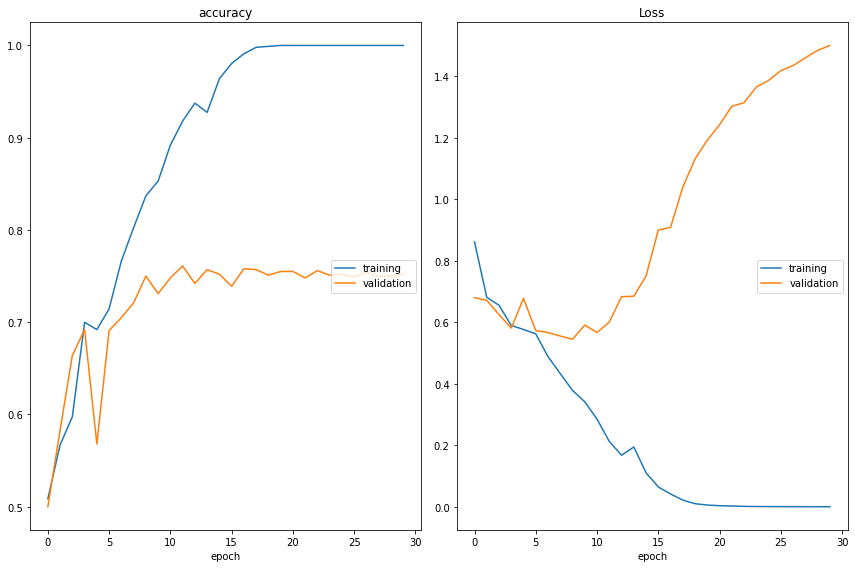

accuracy
	training         	 (min:    0.508, max:    1.000, cur:    1.000)
	validation       	 (min:    0.500, max:    0.761, cur:    0.752)
Loss
	training         	 (min:    0.001, max:    0.862, cur:    0.001)
	validation       	 (min:    0.545, max:    1.501, cur:    1.501)
20/20 [==============================] - 33s 2s/step - loss: 5.4982e-04 - accuracy: 1.0000 - val_loss: 1.5007 - val_accuracy: 0.7520


In [17]:
EPOCHS = 30
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()]) 

Found 1000 images belonging to 2 classes.


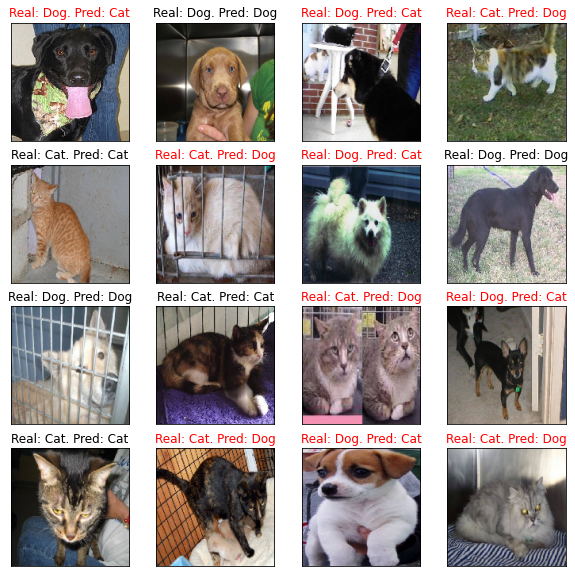

In [18]:
shuffle_val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')
sample_validation_images, sample_validation_labels = next(shuffle_val_data_gen)
predicted = np.round(model.predict(sample_validation_images).flatten())
show_catsdogs(sample_validation_images, sample_validation_labels, predicted)